# Проведение оценки результатов AB-теста

<div class="alert alert-info" role="alert">

<b>Наша задача:</b>
    
Провести оценку результатов A/B-теста. 
    
В вашем распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.

Необходимо оценить корректность проведения теста
    
Проанализировать результаты теста
    
    
    Техническое задание
    Название теста: recommender_system_test;
    Группы: А (контрольная), B (новая платёжная воронка);
    Дата запуска: 2020-12-07;
    Дата остановки набора новых пользователей: 2020-12-21;
    Дата остановки: 2021-01-04;
    Аудитория: 15% новых пользователей из региона EU;
    Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
    Ожидаемое количество участников теста: 6000.
    Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    конверсии в просмотр карточек товаров — событие product_page
    просмотры корзины — product_cart
    покупки — purchase.

<b>Описание данных:</b>
    
 Колонки в `ab_project_marketing_events` - календарь маркетинговых событий на 2020 год:

- `name` — название маркетингового события
- `regions` — регионы, в которых будет проводиться рекламная кампания
- `start_dt` — дата начала кампании
- `finish_dt` — дата завершения кампании

 Колонки в `final_ab_new_users` - все пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года:

- `user_id` — идентификатор пользователя
- `first_date` — дата регистрации
- `region` — регион пользователя
- `device` — устройство, с которого происходила регистрация   
    
 Колонки в `final_ab_events` - все события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года:

- `user_id` — идентификатор пользователя
- `event_dt` — дата и время события
- `event_name` — тип события 
- `details` — дополнительные данные о событии. Например, для покупок, `purchase`, в этом поле хранится стоимость покупки в долларах 
    
 Колонки в `final_ab_participants` - таблица участников тестов:

- `user_id` — идентификатор пользователя
- `ab_test` — название теста
- `group` — группа пользователя      
    

<b>Шаг 1. Загрузим данные, подготовим данные и изучим общую информацию </b>
    
Заменим названия столбцов;
    
Проверим пропуски и типы данных;
    
Добавим столбец даты и времени, а также отдельный столбец дат;   
    

<b>Шаг 2.  Изучим данные приведем их в соответствие с ТЗ</b>
    
Приведем данные к единой таблице, уберем значения не соответствующие ТЗ
    
<b>Шаг 3. Изучим воронку событий</b>  

Посмотрим, какие события есть в логах, как часто они встречаются
    
Посчитаем, сколько пользователей совершали каждое из этих событий
    
Посчитаем долю пользователей, которые хоть раз совершали событие
    
По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки
    
<b>Шаг 4. Проанализируем A/B-тест и построим графики</b>    
    
ТЕСТ: Проверим, находят ли статистические критерии разницу между выборками A и B
    
ТЕСТ: Проверим, имеется ли различия в конверсии групп A и группы B для событий: product_page, product_cart и purchase
    
<b>Шаг 5. Общий вывод</b>   
    
</div>

In [1]:
import pandas as pd
import math as mth
from scipy import stats as st

import numpy as np
from matplotlib import pyplot as plt

import math
from scipy import stats

from datetime import datetime, timedelta

from statsmodels.stats.proportion import proportions_ztest
import warnings

warnings.filterwarnings('ignore')

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Шаг 1. Загрузим данные, подготовим данные и изучим общую информацию

**ab_project_marketing_events**

In [2]:
#marketing_events = pd.read_csv("E:/YP/VP/ID/AB/ab_project_marketing_events.csv")
marketing_events = pd.read_csv('/datasets/ab_project_marketing_events.csv') 
marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
name         14 non-null object
regions      14 non-null object
start_dt     14 non-null object
finish_dt    14 non-null object
dtypes: object(4)
memory usage: 576.0+ bytes


In [3]:
marketing_events

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


Мы обладаем календарем событий в различных регионах за 2020 год. Всего в календаре 14 событий

In [4]:
marketing_events.duplicated().sum()

0

**final_ab_events**

In [5]:
#ab_events = pd.read_csv("E:/YP/VP/ID/AB/final_ab_events.csv")
ab_events = pd.read_csv('/datasets/final_ab_events.csv') 
ab_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
user_id       440317 non-null object
event_dt      440317 non-null object
event_name    440317 non-null object
details       62740 non-null float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


ab_events

In [6]:
ab_events['event_name'].unique()

array(['purchase', 'product_cart', 'product_page', 'login'], dtype=object)

У нас 4 типа события:
- login - посещение страницы регистрации;
- product_page - посещение страницы с продуктом;
- product_cart - просмотр корзины;
- purchase - посещение страницы с оплатой.

Подработаем тип времени

In [7]:
ab_events['event_dt'] = pd.to_datetime(ab_events['event_dt'])

In [8]:
ab_events['event_dt'].describe()

count                  440317
unique                 267268
top       2020-12-23 02:37:24
freq                       10
first     2020-12-07 00:00:33
last      2020-12-30 23:36:33
Name: event_dt, dtype: object

Наши данные начинаются с 07 декабря 2020 года и заканчикаются 30 декабрем 2020 года

In [9]:
ab_events['user_id'].nunique()

58703

Данные с 58703 уникальными пользователями

Добавим день совершения события

In [10]:
ab_events['day'] = ab_events['event_dt'].dt.day
ab_events['date'] = ab_events['event_dt'].dt.date
ab_events

,user_id,event_dt,event_name,details,day,date
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99,7,2020-12-07
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99,7,2020-12-07
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99,7,2020-12-07
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,7,2020-12-07
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99,7,2020-12-07
...,...,...,...,...,...,...
440312,245E85F65C358E08,2020-12-30 19:35:55,login,NaN,30,2020-12-30
440313,9385A108F5A0A7A7,2020-12-30 10:54:15,login,NaN,30,2020-12-30
440314,DB650B7559AC6EAC,2020-12-30 10:59:09,login,NaN,30,2020-12-30
440315,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,NaN,30,2020-12-30


In [11]:
ab_events.duplicated().sum()

0

**final_ab_new_users**

In [12]:
#new_users = pd.read_csv("E:/YP/VP/ID/AB/final_ab_new_users.csv")
new_users = pd.read_csv('/datasets/final_ab_new_users.csv') 
new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
user_id       61733 non-null object
first_date    61733 non-null object
region        61733 non-null object
device        61733 non-null object
dtypes: object(4)
memory usage: 1.9+ MB


In [13]:
new_users

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone
...,...,...,...,...
61728,1DB53B933257165D,2020-12-20,EU,Android
61729,538643EB4527ED03,2020-12-20,EU,Mac
61730,7ADEE837D5D8CBBD,2020-12-20,EU,PC
61731,1C7D23927835213F,2020-12-20,EU,iPhone


In [14]:
new_users['user_id'].nunique()

61733

В наших данный 61733 новых уникальных пользователя

In [15]:
region_group = new_users.groupby(['region']).agg({'user_id': ['count']}).reset_index()
region_group

,region,user_id
,,count
0,APAC,3153
1,CIS,3155
2,EU,46270
3,N.America,9155


Большую часть пользователей составляют из региона EU, далее идут пользователи из N.America и малую долю занимают APAC и CIS

Подработаем тип времени

In [16]:
new_users['first_date'] = pd.to_datetime(new_users['first_date'])
new_users

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone
...,...,...,...,...
61728,1DB53B933257165D,2020-12-20,EU,Android
61729,538643EB4527ED03,2020-12-20,EU,Mac
61730,7ADEE837D5D8CBBD,2020-12-20,EU,PC
61731,1C7D23927835213F,2020-12-20,EU,iPhone


In [17]:
new_users['first_date'].describe()

count                   61733
unique                     17
top       2020-12-21 00:00:00
freq                     6290
first     2020-12-07 00:00:00
last      2020-12-23 00:00:00
Name: first_date, dtype: object

Наши данные начинаются с 07 декабря 2020 года и заканчикаются 23 декабрем 2020 года

Подработаем тип времени

In [18]:
new_users['first_date'] = pd.to_datetime(new_users['first_date'])

Добавим день совершения события

In [19]:
new_users['day'] = new_users['first_date'].dt.day

In [20]:
new_users.duplicated().sum()

0

**final_ab_participants**

In [21]:
#participants = pd.read_csv("E:/YP/VP/ID/AB/final_ab_participants.csv")
participants = pd.read_csv('/datasets/final_ab_participants.csv') 
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
user_id    18268 non-null object
group      18268 non-null object
ab_test    18268 non-null object
dtypes: object(3)
memory usage: 428.3+ KB


In [22]:
participants

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test
...,...,...,...
18263,1D302F8688B91781,B,interface_eu_test
18264,3DE51B726983B657,A,interface_eu_test
18265,F501F79D332BE86C,A,interface_eu_test
18266,63FBE257B05F2245,A,interface_eu_test


In [23]:
participants['ab_test'].unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

По мимо нашего АВ-теста recommender_system_test параллельно проводится еще один тест interface_eu_test

In [24]:
participants_system_test = participants.query('ab_test == "recommender_system_test"')

In [25]:
participants_system_test['user_id'].nunique()

6701

Число уникальных пользователей АВ-теста recommender_system_test составляет 6701 человек

In [26]:
participants_system_test_group = participants_system_test.pivot_table(index="group", values="user_id", aggfunc = 'count')
participants_system_test_group

,user_id
group,
A,3824
B,2877


В группе А немного больше пользователей, чем в группе В

In [27]:
participants.duplicated().sum()

0

<div class="alert alert-success">
<b>Шаг 1. Вывод:</b>

Данные представляют 4 датасета:

-`ab_project_marketing_events` - календарь маркетинговых событий на 2020 год:

    Мы обладаем календарем событий в различных регионах за 2020 год. Всего в календаре 14 событий.
    
-`final_ab_new_users` - все пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года:

    В данных 61733 новых уникальных пользователя, большую часть которых составляют из региона EU, далее идут пользователи из N.America и малую долю занимают APAC и CIS, которые зарегестрировались с 07 декабря 2020 года по 23 декабрем 2020 года    

-`final_ab_events` - все события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года:

    У нас 4 типа события:
        - login - посещение страницы регистрации;
        - product_page - посещение страницы с продуктом;
        - product_cart - просмотр корзины;
        - purchase - посещение страницы с оплатой.
    В данных 58703 новых уникальных пользователя, которые совершили события с 07 декабря 2020 года по 30 декабрем 2020 года

-`final_ab_participants` - таблица участников тестов:
    
    По мимо нашего АВ-теста recommender_system_test параллельно проводится еще один тест interface_eu_test. 
    Число уникальных пользователей АВ-теста recommender_system_test составляет 6701 человек.    
    В группе А немного больше пользователей, чем в группе В  
    
Дубликаты в данных отсутствуют
    
</div>

# Шаг 2.  Изучим данные приведем их в соответствие с ТЗ

**Дата запуска: 2020-12-07**

**Дата остановки набора новых пользователей: 2020-12-21**

**Дата остановки: 2021-01-04**

Дата остановки набора новых пользователей составляет 21 декабря 2020 года, наши данные представлены с набором новых пользователей до 23 декабрем 2020 года. Отбросим даты не входящие в ТЗ

In [28]:
new_users_df = new_users.query('day <= 21')
new_users_df

,user_id,first_date,region,device,day
0,D72A72121175D8BE,2020-12-07,EU,PC,7
1,F1C668619DFE6E65,2020-12-07,N.America,Android,7
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC,7
3,50734A22C0C63768,2020-12-07,EU,iPhone,7
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone,7
...,...,...,...,...,...
61728,1DB53B933257165D,2020-12-20,EU,Android,20
61729,538643EB4527ED03,2020-12-20,EU,Mac,20
61730,7ADEE837D5D8CBBD,2020-12-20,EU,PC,20
61731,1C7D23927835213F,2020-12-20,EU,iPhone,20


Посмотрим на поведенческую активность за наш период

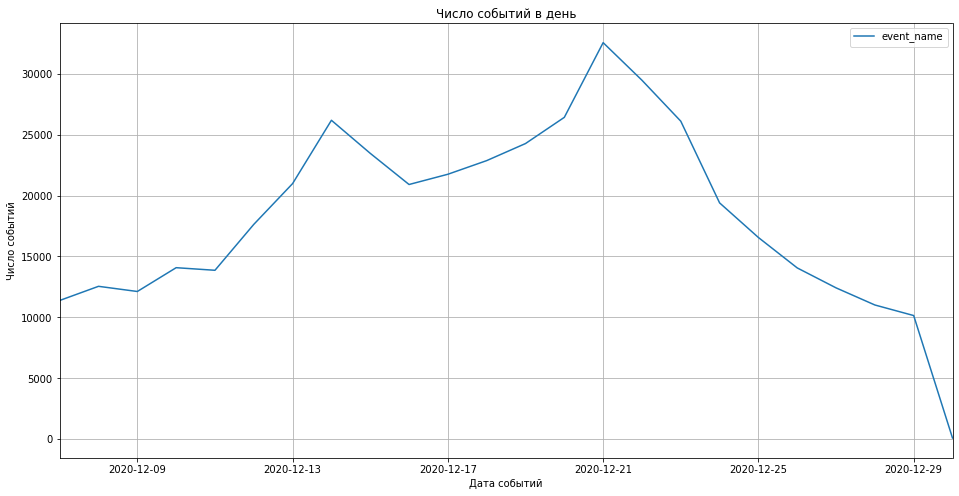

In [29]:
ab_events_groupby = ab_events.groupby(['date']).agg({'event_name': 'count'}).reset_index() 
ab_events_groupby.plot(y='event_name', x='date', grid=True, figsize=(16, 8))
plt.title('Число событий в день')
plt.xlabel('Дата событий')
plt.ylabel('Число событий');

Дата остановки теста определена как 04 января, по данным совершения события новых пользователей, последняя дата события составляет 30 декаабря. Это скорее всего связано с тем, что в регионе EU начинаются рождественские каникулы, все магазины закрываются, а покупки совершаются заранее. Так мы видим увеличение числа событий в период с 10 по 20-е декабря и потом с 20-го декабря уменьшение активности до минимальных значений. Данное событие скорее всего сильно окажет влияние на наш тест

**Пересечение тестовой аудитории с конкурирующим тестом**

In [30]:
participants['user_id'].nunique()

16666

Мы имеем 16666 уникальных пользователя по обоим тестам

In [31]:
participants_system_test['user_id'].nunique()

6701

In [32]:
participants_interface_eu_test = participants.query('ab_test == "interface_eu_test"')
participants_interface_eu_test['user_id'].nunique()

11567

Число уникальных пользователей теста 'interface_eu_test' составляет 11567 человек.

Число уникальных пользователей теста 'recommender_system_test' составляет 6701 человек.

In [33]:
(participants_interface_eu_test['user_id'].nunique() + participants_system_test['user_id'].nunique()
 - participants['user_id'].nunique())

1602

Пересечение аудитории 2-х тестов составляет 1602 человека. Второй тест более глобальный и может оказывать больше влияние на поведение пользователей. Но мы не можем убрать данных пересекающихся пользователей, поскольку не выполним пунк ТЗ о количестве участников в 6000. Оставляем уникальных пользователей теста 'interface_eu_test' без изменений

**Совпадение теста и маркетинговых событий, другие проблемы временных границ теста**

Наш тест попадает под событие 'Christmas&New Year Promo' проходящий в EU и N.America с 25 декабря по 03 января, что будет влиять на его результаты.

Также наш тест попадает под событие 'CIS New Year Gift Lottery' проходящий в CIS с 30 декабря по 07 января, поскольку данное событие проходит в другом регионе, влиять на результаты оно не сможет.

**Аудитория: 15% новых пользователей из региона EU**

Объединим таблицы с пользователями АВ-теста и пользователями, зарегистрировавшимися в интернет-магазине в период с 7 по 21 декабря 2020 года

In [34]:
participants_new_users = participants_system_test.merge(new_users, left_on='user_id', right_on='user_id', how='left')
participants_new_users

,user_id,group,ab_test,first_date,region,device,day
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,7
1,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone,20
2,DABC14FDDFADD29E,A,recommender_system_test,2020-12-08,EU,Mac,8
3,04988C5DF189632E,A,recommender_system_test,2020-12-14,EU,iPhone,14
4,482F14783456D21B,B,recommender_system_test,2020-12-14,EU,PC,14
...,...,...,...,...,...,...,...
6696,053FB26D6D49EDDC,A,recommender_system_test,2020-12-10,N.America,Android,10
6697,9D263B8EF15CF188,B,recommender_system_test,2020-12-16,N.America,Mac,16
6698,F2FBBA33F37DEC46,A,recommender_system_test,2020-12-18,APAC,Mac,18
6699,29C92313A98B1176,B,recommender_system_test,2020-12-07,APAC,Android,7


In [35]:
participants_new_users_region = participants_new_users.pivot_table(index="region", values="user_id", aggfunc = 'count')
participants_new_users_region

,user_id
region,
APAC,72
CIS,55
EU,6351
N.America,223


Наши пользователи АВ-теста оказались зарегестрированы в основном в регионе EU, но малая их доля находится во всех остальных регионах APAC, CIS и N.America. Это скорее все связано с тем, что пользователь мог совершать в это время поездку в один из регионов. Оставим пользователей АВ-теста без изменений

In [36]:
new_users_EU = new_users.query('region == "EU"')
#new_users_EU

In [37]:
new_users_EU_percent = participants_new_users['user_id'].nunique() / new_users_EU['user_id'].nunique()
print('Процент новых пользователей из региона EU: {:.1%}'.format(new_users_EU_percent))

Процент новых пользователей из региона EU: 14.5%


Процент новых пользователей из региона EU составляет 14.5% и очень близок к ТЗ

**Ожидаемое количество участников теста: 6000**

In [38]:
print('Количество участников теста: {:}'.format(participants_new_users['user_id'].nunique()))

Количество участников теста: 6701


Количество участников теста составляет 6701 человек, что соответствует ТЗ

**Ожидаемый эффект: за 14 дней с момента регистрации в системе**

Объединим таблицы с пользователями АВ-теста и с пользователями совершившим события

In [39]:
participants_events_EU = participants_new_users.merge(ab_events, left_on='user_id', right_on='user_id', how='left')
participants_events_EU['day_y'] = participants_events_EU['day_y'].fillna(0)
participants_events_EU['day_y'] = participants_events_EU['day_y'].astype('int')   
participants_events_EU.sample(5)

,user_id,group,ab_test,first_date,region,device,day_x,event_dt,event_name,details,day_y,date
3941,A0E1AD0FF8953659,A,recommender_system_test,2020-12-11,EU,iPhone,11,2020-12-11 08:54:43,login,NaN,11,2020-12-11
27191,2A13C7A010142F61,B,recommender_system_test,2020-12-15,N.America,Android,15,2020-12-15 11:39:40,product_page,NaN,15,2020-12-15
26294,800AF45A68291849,A,recommender_system_test,2020-12-07,N.America,Android,7,2020-12-07 01:48:51,login,NaN,7,2020-12-07
14935,49EA242586C87836,B,recommender_system_test,2020-12-07,EU,iPhone,7,2020-12-12 04:30:43,product_page,NaN,12,2020-12-12
14973,7347C03E6A300EFD,A,recommender_system_test,2020-12-18,EU,Android,18,2020-12-24 17:35:22,product_cart,NaN,24,2020-12-24


Определим время прошедшее от регестрации

In [40]:
participants_events_EU['delta'] = participants_events_EU['day_y'] - participants_events_EU['day_x']
#participants_events_EU.sample(10)

Уберем события, которые были позже 14 дней с момента регистрации

In [41]:
AB_events_EU_delta = participants_events_EU.query('delta < 14')

In [42]:
AB_events_EU = AB_events_EU_delta.loc[:, ['user_id', 'group', 'event_name', 'date']]
AB_events_EU

,user_id,group,event_name,date
0,D1ABA3E2887B6A73,A,purchase,2020-12-07
2,D1ABA3E2887B6A73,A,product_cart,2020-12-07
4,D1ABA3E2887B6A73,A,product_page,2020-12-07
6,D1ABA3E2887B6A73,A,login,2020-12-07
8,A7A3664BD6242119,A,product_page,2020-12-20
...,...,...,...,...
27719,6715343AFBA285AE,B,login,2020-12-07
27720,6715343AFBA285AE,B,login,2020-12-08
27721,6715343AFBA285AE,B,login,2020-12-09
27722,6715343AFBA285AE,B,login,2020-12-10


<div class="alert alert-success">
<b>Шаг 2. Вывод:</b>

Дата остановки набора новых пользователей составляет 21 декабря 2020 года, наши данные представлены с набором новых пользователей до 23 декабрем 2020 года. Отбросим даты не входящие в ТЗ
    
Дата остановки теста определена как 04 января, по данным совершения события новых пользователей, последняя дата события составляет 30 декаабря. Это скорее всего связано с тем, что в регионе EU начинаются рождественские каникулы, все магазины закрываются, а покупки совершаются заранее. Так мы видим увеличение числа событий в период с 10 по 20-е декабря и потом с 20-го декабря уменьшение активности до минимальных значений. Данное событие скорее всего сильно окажет влияние на наш тест    
    
Пересечение аудитории 2-х тестов составляет 1602 человека. Второй тест более глобальный и может оказывать больше влияние на поведение пользователей. Но мы не можем убрать данных пересекающихся пользователей, поскольку не выполним пунк ТЗ о количестве участников в 6000. Оставляем уникальных пользователей теста 'interface_eu_test' без изменений    
    
Наш тест попадает под событие 'Christmas&New Year Promo' проходящий в EU и N.America с 25 декабря по 03 января, что будет влиять на его результаты.

Также наш тест попадает под событие 'CIS New Year Gift Lottery' проходящий в CIS с 30 декабря по 07 января, поскольку данное событие проходит в другом регионе, влиять на результаты оно не сможет.
    
Наши пользователи АВ-теста оказались зарегестрированы в основном в регионе EU, но малая их доля находится во всех остальных регионах APAC, CIS и N.America. Это скорее все связано с тем, что пользователь мог совершать в это время поездку в один из регионов. Оставим пользователей АВ-теста без изменений
    
Процент новых пользователей из региона EU составляет 14.5% и очень близок к ТЗ    
    
Количество участников теста составляет 6701 человек, что соответствует ТЗ
    
Датасет AB_events_EU содержит события, которые были позже 14 дней с момента регистрации согласно ТЗ
    
Проводить тест в данных условиях некорректно поскольку он попадаетпод рождественские каникулы, которые сильно влияют на покупательскую способность в данном регионе. В последних числах декабря покупательская способность падает до минимальных значений за указанный период, далее она отсутствует, что очень сильно отразится на результатах АВ-теста
    
</div>

# Шаг 3. Изучим воронку событий

**Посмотрим, какие события есть в логах, как часто они встречаются**

In [43]:
AB_events_EU_pivot = AB_events_EU.pivot_table(index="event_name", values="user_id", aggfunc = 'count').sort_values(
    'user_id', ascending=False)

In [44]:
AB_events_EU_pivot = AB_events_EU_pivot.reindex(['login','product_page','product_cart','purchase'])
AB_events_EU_pivot

,user_id
event_name,
login,10794
product_page,6684
product_cart,3146
purchase,3232


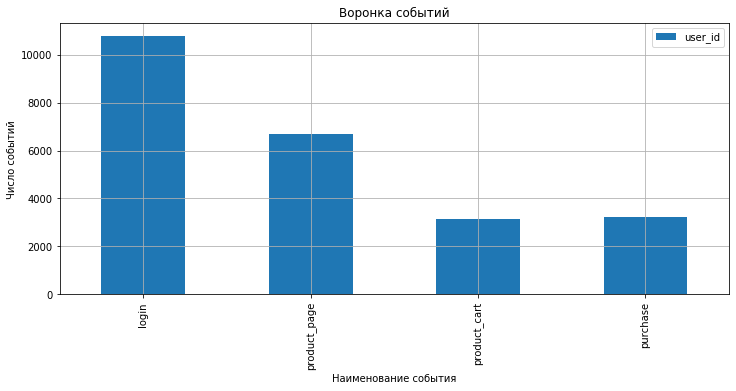

In [45]:
AB_events_EU_pivot.plot(kind='bar', y='user_id', grid=True, figsize=(12, 5))
plt.title('Воронка событий')
plt.xlabel('Наименование события')
plt.ylabel('Число событий');

4 события при покупке товара распределены следующим образом:

    - посещение страницы регистрации (login) 10 794 события;
    - посещение страницы с продуктом (product_page) 6684 события;
    - просмотр корзины (product_cart) 3146 события;
    - посещение страницы с оплатой (purchase) 3232 события.
    
Посещение страницы с оплатой немного больше просмотров корзины, это скорее всего зависит от возможности оплаты без перехода в корзину.

**Посчитаем, сколько пользователей совершали каждое из этих событий**

In [46]:
AB_events_EU_pivot_unique = AB_events_EU.pivot_table(index="event_name", values="user_id", aggfunc = 'nunique').sort_values(
    'user_id', ascending=False)

In [47]:
AB_events_EU_pivot_unique = AB_events_EU_pivot_unique.reindex(['login','product_page','product_cart','purchase'])
AB_events_EU_pivot_unique

,event_name,user_id
event_name,,
login,1,3674
product_page,1,2303
product_cart,1,1079
purchase,1,1128


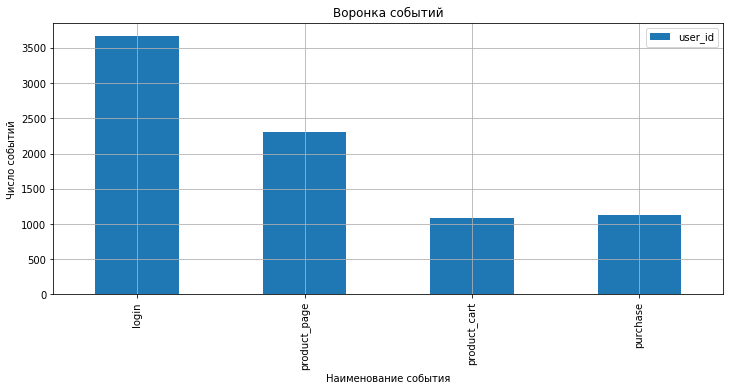

In [48]:
AB_events_EU_pivot_unique.plot(kind='bar', y='user_id', grid=True, figsize=(12, 5))
plt.title('Воронка событий')
plt.xlabel('Наименование события')
plt.ylabel('Число событий');

События совершенные уникальными пользователями при покупке товара распределены следующим образом:

    - посещение страницы регистрации (login) 3674 пользователей;
    - посещение страницы с продуктом (product_page) 2303 пользователей;
    - просмотр корзины (product_cart) 1079 пользователей;
    - посещение страницы с оплатой (purchase) 1128 пользователей.

**Посчитаем долю пользователей, которые хоть раз совершали событие**

In [49]:
AB_events_EU_groupby_unique = AB_events_EU.groupby(['event_name']).agg({'user_id': ['nunique']}).reset_index()
AB_events_EU_groupby_unique.columns = ['event_name', 'user_id_nunique']
AB_events_EU_groupby_unique = AB_events_EU_groupby_unique.sort_values('user_id_nunique', ascending=False)
AB_events_EU_groupby_unique['per'] = (AB_events_EU_groupby_unique['user_id_nunique'] / 
                        AB_events_EU_groupby_unique['user_id_nunique'].loc[0]).map(lambda x: "{0:.1%}".format(x))
AB_events_EU_groupby_unique

,event_name,user_id_nunique,per
0,login,3674,100.0%
2,product_page,2303,62.7%
3,purchase,1128,30.7%
1,product_cart,1079,29.4%


Доля пользователей при покупке товара распределена следующим образом:

    - доля посещения страницы с продуктом (product_page) составляет 62.7% от общего числа зарегестрировааных пользователей;
    - доля просмотра корзины (product_cart) составляет 29.4% от общего числа зарегестрировааных пользователей;
    - доля посещения страницы с оплатой (purchase) составляет 30.7% от общего числа зарегестрировааных пользователей.
    
Доля пользователей, которая доходит от первого события до оплаты составляет 29.4%

**По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки**

In [50]:
print('Доля пользователей, которая проходит на следующий шаг воронки "product_cart": {:.1%}'.
      format(AB_events_EU_groupby_unique['user_id_nunique'].loc[1] / AB_events_EU_groupby_unique['user_id_nunique'].loc[2]))

Доля пользователей, которая проходит на следующий шаг воронки "product_cart": 46.9%


In [51]:
print('Доля пользователей, которая проходит на следующий шаг воронки "purchase": {:.1%}'.
      format(AB_events_EU_groupby_unique['user_id_nunique'].loc[3] / AB_events_EU_groupby_unique['user_id_nunique'].loc[1]))

Доля пользователей, которая проходит на следующий шаг воронки "purchase": 104.5%


Доля пользователей, которая проходит на следующий шаг воронки:

    - доля пользователей, которая проходит на страницу с продуктом: 62.7%;
    - доля пользователей, которая проходит на просмотр корзины: 46.9%;
    - доля пользователей, которая проходит на страницу с оплатой: 104.5%.
    
 Доля тех, кто оплачивает товары без перехода в корзину составляет 4.5%.

Больше всего пользователей теряется на втором шаге, то есть при переходе на просмотр корзины -  46.9% пользователей переходят к просмотру корзины.

<div class="alert alert-success">
<b>Шаг 3. Вывод:</b>

4 события при покупке товара распределены следующим образом:
    
    - посещение страницы регистрации (login) 10 794 события;
    - посещение страницы с продуктом (product_page) 6684 события;
    - просмотр корзины (product_cart) 3146 события;
    - посещение страницы с оплатой (purchase) 3232 события.
    
Посещение страницы с оплатой немного больше просмотров корзины, это скорее всего зависит от возможности оплаты без перехода в корзину.
    
События совершенные уникальными пользователями при покупке товара распределены следующим образом:

    - посещение страницы регистрации (login) 3674 пользователей;
    - посещение страницы с продуктом (product_page) 2303 пользователей;
    - просмотр корзины (product_cart) 1079 пользователей;
    - посещение страницы с оплатой (purchase) 1128 пользователей.
    
Доля пользователей при покупке товара распределена следующим образом:

    - доля посещения страницы с продуктом (product_page) составляет 62.7% от общего числа зарегестрировааных пользователей;
    - доля просмотра корзины (product_cart) составляет 29.4% от общего числа зарегестрировааных пользователей;
    - доля посещения страницы с оплатой (purchase) составляет 30.7% от общего числа зарегестрировааных пользователей.
    
Доля пользователей, которая доходит от первого события до оплаты составляет 29.4%
    
Доля пользователей, которая проходит на следующий шаг воронки:

    - доля пользователей, которая проходит на страницу с продуктом: 62.7%;
    - доля пользователей, которая проходит на просмотр корзины: 46.9%;
    - доля пользователей, которая проходит на страницу с оплатой: 104.5%.
    
Доля тех, кто оплачивает товары без перехода в корзину составляет 4.5%.

Больше всего пользователей теряется на втором шаге, то есть при переходе на просмотр корзины -  46.9% пользователей переходят к просмотру корзины.
    
Для увеличения конверсии надо будет посмотреть на то, как пользователи ведут себя на сайте: 

Переход на <b> страницу с продуктом </b> - по каким ссылкам переходят пользователи; на каких продуктах они отваливаются; изучить тепловую карту кликов и сделать выводы какие страницы с продуктами нужно изменить; вывести наиболее интерсное предложение на главную страницу; посмотреть, как влияет дизайт страниц приложения (может отталкивать); Упростить доступ к каталогу или сделать его интуитивно понятным.

Переход на <b> просмотр корзины </b> - расположить значок корзины в доступном месте или там где его всегда видно, упростить форму корзины, возможно некоторым пользователям  она не нравится.

Посещение <b>страницы с оплатой </b> - при оплате товара расположить значок корзины на видном месте для возможности ее пополнения. 
       
</div>

# Шаг 4. Проанализируем A/B-тест и построим графики

### ТЕСТ: Проверим, находят ли статистические критерии разницу между выборками A и B

In [52]:
AB_events_EU

,user_id,group,event_name,date
0,D1ABA3E2887B6A73,A,purchase,2020-12-07
2,D1ABA3E2887B6A73,A,product_cart,2020-12-07
4,D1ABA3E2887B6A73,A,product_page,2020-12-07
6,D1ABA3E2887B6A73,A,login,2020-12-07
8,A7A3664BD6242119,A,product_page,2020-12-20
...,...,...,...,...
27719,6715343AFBA285AE,B,login,2020-12-07
27720,6715343AFBA285AE,B,login,2020-12-08
27721,6715343AFBA285AE,B,login,2020-12-09
27722,6715343AFBA285AE,B,login,2020-12-10


In [53]:
AB_events_EU['user_id'].nunique()

6701

In [54]:
group_A = AB_events_EU.query('group == "A"')
test_A = group_A['user_id'].nunique()

In [55]:
group_B = AB_events_EU.query('group == "B"')
test_B = group_B['user_id'].nunique()

In [56]:
all_test_AB = test_A + test_B

In [57]:
test_A / all_test_AB

0.5706610953589016

<b>Нулевая гипотеза:</b>  Среднее генеральной совокупности числа пользователей выборки группы А и выборки группы В равны между собой.

<b>Альтернативная гипотеза:</b>  Среднее генеральной совокупности числа пользователей выборки группы А и выборки группы В <b>не</b> равны между собой.

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid " > <b>Комментарии от ревьюера: </b> 

Очень хорошо, что ты не забыл про формулировку гипотез. Это важный пункт в подобного рода задачах
</div>

In [58]:
alpha = 0.05
alpha = alpha / 2
pvalue = proportions_ztest(test_A, all_test_AB, value = 0.5)[1]
print('p-value: {}'.format(pvalue))
if pvalue >= alpha: 
    print('Нулевая гипотеза не отвергается: вероятность попасть в группу А составляет 50%')
else:
    print('Нулевая гипотеза отвергается: вероятность попасть в группу А отличается от 50%')

p-value: 1.50536508194716e-31
Нулевая гипотеза отвергается: вероятность попасть в группу А отличается от 50%


### ТЕСТ: Проверим, имеется ли различия в долях переходов групп A и группы B для событий: login, product_page, product_cart и purchase

<div class="alert alert-info"> <b>Комментарии студента:</b> 

Группа А больше группы В, вероятность попасть в группу А отличается от 50%.

Мы смотрим на изменение показателей во времени по различным группам.

</div>

Мы приняли уровень статистической значимости для для нашего теста в 5%. Коррекция уровня значимости наших гипотез принята для одновременного проведения 3-х тестов. Уровень статистической значимости alpha был выбран 0.0167 или 0.05/3.

In [59]:
alpha = 0.05
alpha = alpha / 3
alpha

0.016666666666666666

**Определим число уникальных пользователей совершавших события login, product_page, product_cart и purchase**

In [60]:
login_A = AB_events_EU.query('group == "A" and event_name == "login"')
login_A_nunique = login_A['user_id'].nunique()
login_B = AB_events_EU.query('group == "B" and event_name == "login"')
login_B_nunique = login_B['user_id'].nunique()

In [61]:
product_page_A = AB_events_EU.query('group == "A" and event_name == "product_page"')
product_page_A_nunique = product_page_A['user_id'].nunique()
product_page_B = AB_events_EU.query('group == "B" and event_name == "product_page"')
product_page_B_nunique = product_page_B['user_id'].nunique()

In [62]:
product_cart_A = AB_events_EU.query('group == "A" and event_name == "product_cart"')
product_cart_A_nunique = product_cart_A['user_id'].nunique()
product_cart_B = AB_events_EU.query('group == "B" and event_name == "product_cart"')
product_cart_B_nunique = product_cart_B['user_id'].nunique()

In [63]:
purchase_A = AB_events_EU.query('group == "A" and event_name == "purchase"')
purchase_A_nunique = purchase_A['user_id'].nunique()
purchase_B = AB_events_EU.query('group == "B" and event_name == "purchase"')
purchase_B_nunique = purchase_B['user_id'].nunique()

**Проверим, находят гипотезу о равенстве долей между выборками групп A и группы B для перехода с события login на product_page**

<b>Нулевая гипотеза:</b>  Пропорций двух генеральных совокупностей выборки группы A и выборки группы В для события product_page равны.

<b>Альтернативная гипотеза:</b>  Пропорций двух генеральных совокупностей выборки группы A и выборки группы В для события product_page  <b>не</b> равны.

In [64]:
successes = np.array([product_page_A_nunique, product_page_B_nunique])
trials = np.array([login_A_nunique, login_B_nunique])

# пропорция успехов в первой группе:
p1 = successes[0]/trials[0]

# пропорция успехов во второй группе:
p2 = successes[1]/trials[1]

# пропорция успехов в комбинированном датасете:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# разница пропорций в датасетах
difference = p1 - p2 

In [65]:
# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)

In [66]:
# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(
    p_combined * (1 - p_combined) * (1 / trials[0] + 1 / trials[1])
)

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    ) 

p-значение:  5.084368080776613e-06
Отвергаем нулевую гипотезу: между долями есть значимая разница


In [67]:
print('Ожидаемый эффект для события "product_page": {:.1%}'.
      format(product_page_A_nunique / login_A_nunique *1.1))

Ожидаемый эффект для события "product_page": 71.3%


In [68]:
print('Полученный эффект для события "product_page": {:.1%}'.
      format(product_page_B_nunique / login_B_nunique))

Полученный эффект для события "product_page": 56.4%


Для события "product_page" произошло значительное уменьшение показателей вместо прогнозируемого увеличения на 10%

**Проверим, находят гипотезу о равенстве долей между выборками групп A и группы B для перехода с события product_page на product_cart**

<b>Нулевая гипотеза:</b>  Пропорций двух генеральных совокупностей выборки группы A и выборки группы В для события product_cart равны.

<b>Альтернативная гипотеза:</b>  Пропорций двух генеральных совокупностей выборки группы A и выборки группы В для события product_cart  <b>не</b> равны.

In [69]:
successes = np.array([product_cart_A_nunique, product_cart_B_nunique])
trials = np.array([product_page_A_nunique, product_page_B_nunique])

# пропорция успехов в первой группе:
p1 = successes[0]/trials[0]

# пропорция успехов во второй группе:
p2 = successes[1]/trials[1]

# пропорция успехов в комбинированном датасете:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# разница пропорций в датасетах
difference = p1 - p2 

In [70]:
# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)

In [71]:
# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(
    p_combined * (1 - p_combined) * (1 / trials[0] + 1 / trials[1])
)

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    ) 

p-значение:  0.32062049601759046
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [72]:
print('Ожидаемый эффект для события "product_page": {:.1%}'.
      format(product_cart_A_nunique / product_page_A_nunique *1.1))

Ожидаемый эффект для события "product_page": 50.9%


In [73]:
print('Полученный эффект для события "product_page": {:.1%}'.
      format(product_cart_B_nunique / product_page_B_nunique))

Полученный эффект для события "product_page": 48.8%


Для события "product_cart" произошло незначительное уменьшение показателей вместо прогнозируемого увеличения на 10%

**Проверим, находят гипотезу о равенстве долей между выборками групп A и группы B для перехода с события product_cart на purchase**

<b>Нулевая гипотеза:</b>  Пропорций двух генеральных совокупностей выборки группы A и выборки группы В для события purchase равны.

<b>Альтернативная гипотеза:</b>  Пропорций двух генеральных совокупностей выборки группы A и выборки группы В для события purchase  <b>не</b> равны.

In [74]:
successes = np.array([product_cart_A_nunique, product_cart_B_nunique]) 
trials = np.array([purchase_A_nunique, purchase_B_nunique])

# пропорция успехов в первой группе:
p1 = successes[0]/trials[0]

# пропорция успехов во второй группе:
p2 = successes[1]/trials[1]

# пропорция успехов в комбинированном датасете:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# разница пропорций в датасетах
difference = p1 - p2 

In [75]:
# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)

In [76]:
# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(
    p_combined * (1 - p_combined) * (1 / trials[0] + 1 / trials[1])
)

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    ) 

p-значение:  0.00041675077401071015
Отвергаем нулевую гипотезу: между долями есть значимая разница


In [78]:
print('Ожидаемый эффект для события "product_page": {:.1%}'.
      format(purchase_A_nunique / product_cart_A_nunique *1.1))

Ожидаемый эффект для события "product_page": 116.4%


In [79]:
print('Полученный эффект для события "product_page": {:.1%}'.
      format(purchase_B_nunique / product_cart_B_nunique))

Полученный эффект для события "product_page": 100.4%


Для события "purchase" произошло значительное уменьшение показателей вместо прогнозируемого увеличения на 10%

<div class="alert alert-success">
<b>Шаг 4. Вывод:</b>

Мы провели два теста и получили следующие результаты:
    
<b>ТЕСТ_1: Проверим, находят ли статистические критерии разницу между выборками A и B</b>
    
<b>Нулевая гипотеза:</b>  Среднее генеральной совокупности числа пользователей выборки группы А и выборки группы В равны между собой.

<b>Альтернативная гипотеза:</b>  Среднее генеральной совокупности числа пользователей выборки группы А и выборки группы В <b>не</b> равны между собой.
    
<b>Нулевая гипотеза отвергается: вероятность попасть в группу А отличается от 50%</b>
    
<b>ТЕСТ: Проверим, имеется ли различия в долях переходов групп A и группы B для событий: login, product_page, product_cart и purchase</b>   

<b>Нулевая гипотеза:</b>  Пропорций двух генеральных совокупностей выборки группы A и выборки группы В для события product_page равны.

<b>Альтернативная гипотеза:</b>  Пропорций двух генеральных совокупностей выборки группы A и выборки группы В для события product_page  <b>не</b> равны.    
    
Отвергаем нулевую гипотезу: между долями есть значимая разница    
    
Для события "product_page" произошло значительное уменьшение показателей вместо прогнозируемого увеличения на 10%
        
<b>Нулевая гипотеза:</b>  Пропорций двух генеральных совокупностей выборки группы A и выборки группы В для события product_cart равны.

<b>Альтернативная гипотеза:</b>  Пропорций двух генеральных совокупностей выборки группы A и выборки группы В для события product_cart  <b>не</b> равны.    
    
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными    
    
Для события "product_cart" произошло незначительное уменьшение показателей вместо прогнозируемого увеличения на 10%
    
<b>Нулевая гипотеза:</b>  Пропорций двух генеральных совокупностей выборки группы A и выборки группы В для события purchase равны.

<b>Альтернативная гипотеза:</b>  Пропорций двух генеральных совокупностей выборки группы A и выборки группы В для события purchase  <b>не</b> равны.    
    
Отвергаем нулевую гипотезу: между долями есть значимая разница    
    
Для события "purchase" произошло значительное уменьшение показателей вместо прогнозируемого увеличения на 10%    
    
<b>Вывод:</b>
    
    Между долями выборки группы A и выборки группы В для события product_pageесть значимая разница, произошло значительное уменьшение показателей;    
    Между долями выборки группы A и выборки группы В для события product_cart нет значимой разницы, произошло незначительное уменьшение показателей;
    Между долями выборки группы A и выборки группы В для события purchase значимая разница, произошло значительное уменьшение показателей.
    
</div>

# Шаг 5. Общий вывод

<div class="alert alert-info" role="alert">
 
Мы провели оценку результатов A/B-теста. 
    
В вашем распоряжении датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.

Оценили корректность проведения теста
    
Проанализировали результаты теста
    
    
    Техническое задание
    Название теста: recommender_system_test;
    Группы: А (контрольная), B (новая платёжная воронка);
    Дата запуска: 2020-12-07;
    Дата остановки набора новых пользователей: 2020-12-21;
    Дата остановки: 2021-01-04;
    Аудитория: 15% новых пользователей из региона EU;
    Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
    Ожидаемое количество участников теста: 6000.
    Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    конверсии в просмотр карточек товаров — событие product_page
    просмотры корзины — product_cart
    покупки — purchase.

<b>Описание данных:</b>
    
 Колонки в `ab_project_marketing_events` - календарь маркетинговых событий на 2020 год:

- `name` — название маркетингового события
- `regions` — регионы, в которых будет проводиться рекламная кампания
- `start_dt` — дата начала кампании
- `finish_dt` — дата завершения кампании

 Колонки в `final_ab_new_users` - все пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года:

- `user_id` — идентификатор пользователя
- `first_date` — дата регистрации
- `region` — регион пользователя
- `device` — устройство, с которого происходила регистрация   
    
 Колонки в `final_ab_events` - все события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года:

- `user_id` — идентификатор пользователя
- `event_dt` — дата и время события
- `event_name` — тип события 
- `details` — дополнительные данные о событии. Например, для покупок, `purchase`, в этом поле хранится стоимость покупки в долларах 
    
 Колонки в `final_ab_participants` - таблица участников тестов:

- `user_id` — идентификатор пользователя
- `ab_test` — название теста
- `group` — группа пользователя      
    

<b>Шаг 1. Загрузим данные, подготовим данные и изучим общую информацию </b>
    
Данные представляют 4 датасета:

-`ab_project_marketing_events` - календарь маркетинговых событий на 2020 год:

    Мы обладаем календарем событий в различных регионах за 2020 год. Всего в календаре 14 событий.
    
-`final_ab_new_users` - все пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года:

    В данных 61733 новых уникальных пользователя, большую часть которых составляют из региона EU, далее идут пользователи из N.America и малую долю занимают APAC и CIS, которые зарегестрировались с 07 декабря 2020 года по 23 декабрем 2020 года    

-`final_ab_events` - все события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года:

    У нас 4 типа события:
        - login - посещение страницы регистрации;
        - product_page - посещение страницы с продуктом;
        - product_cart - просмотр корзины;
        - purchase - посещение страницы с оплатой.
    В данных 58703 новых уникальных пользователя, которые совершили события с 07 декабря 2020 года по 30 декабрем 2020 года

-`final_ab_participants` - таблица участников тестов:
    
    По мимо нашего АВ-теста recommender_system_test параллельно проводится еще один тест interface_eu_test. 
    Число уникальных пользователей АВ-теста recommender_system_test составляет 6701 человек.    
    В группе А немного больше пользователей, чем в группе В    

<b>Шаг 2.  Изучим данные приведем их в соответствие с ТЗ</b>
    
Дата остановки набора новых пользователей составляет 21 декабря 2020 года, наши данные представлены с набором новых пользователей до 23 декабрем 2020 года. Отбросим даты не входящие в ТЗ
    
Дата остановки теста определена как 04 января, по данным совершения события новых пользователей, последняя дата события составляет 30 декаабря. Это скорее всего связано с тем, что в регионе EU начинаются рождественские каникулы, все магазины закрываются, а покупки совершаются заранее. Так мы видим увеличение числа событий в период с 10 по 20-е декабря и потом с 20-го декабря уменьшение активности до минимальных значений. Данное событие скорее всего сильно окажет влияние на наш тест    
    
Пересечение аудитории 2-х тестов составляет 1602 человека. Второй тест более глобальный и может оказывать больше влияние на поведение пользователей. Но мы не можем убрать данных пересекающихся пользователей, поскольку не выполним пунк ТЗ о количестве участников в 6000. Оставляем уникальных пользователей теста 'interface_eu_test' без изменений    
    
Наш тест попадает под событие 'Christmas&New Year Promo' проходящий в EU и N.America с 25 декабря по 03 января, что будет влиять на его результаты.

Также наш тест попадает под событие 'CIS New Year Gift Lottery' проходящий в CIS с 30 декабря по 07 января, поскольку данное событие проходит в другом регионе, влиять на результаты оно не сможет.

    
Наши пользователи АВ-теста оказались зарегестрированы в основном в регионе EU, но малая их доля находится во всех остальных регионах APAC, CIS и N.America. Это скорее все связано с тем, что пользователь мог совершать в это время поездку в один из регионов. Оставим пользователей АВ-теста без изменений
    
Процент новых пользователей из региона EU составляет 14.5% и очень близок к ТЗ    
    
Количество участников теста составляет 6701 человек, что соответствует ТЗ
    
Датасет AB_events_EU содержит события, которые были позже 14 дней с момента регистрации согласно ТЗ
    
Проводить тест в данных условиях некорректно поскольку он попадаетпод рождественские каникулы, которые сильно влияют на покупательскую способность в данном регионе. В последних числах декабря покупательская способность падает до минимальных значений за указанный период, далее она отсутствует, что очень сильно отразится на результатах АВ-теста
    
<b>Шаг 3. Изучим воронку событий</b>  

4 события при покупке товара распределены следующим образом:
    
    - посещение страницы регистрации (login) 10 794 события;
    - посещение страницы с продуктом (product_page) 6684 события;
    - просмотр корзины (product_cart) 3146 события;
    - посещение страницы с оплатой (purchase) 3232 события.
    
Посещение страницы с оплатой немного больше просмотров корзины, это скорее всего зависит от возможности оплаты без перехода в корзину.
    
События совершенные уникальными пользователями при покупке товара распределены следующим образом:

    - посещение страницы регистрации (login) 3674 пользователей;
    - посещение страницы с продуктом (product_page) 2303 пользователей;
    - просмотр корзины (product_cart) 1079 пользователей;
    - посещение страницы с оплатой (purchase) 1128 пользователей.
    
Доля пользователей при покупке товара распределена следующим образом:

    - доля посещения страницы с продуктом (product_page) составляет 62.7% от общего числа зарегестрировааных пользователей;
    - доля просмотра корзины (product_cart) составляет 29.4% от общего числа зарегестрировааных пользователей;
    - доля посещения страницы с оплатой (purchase) составляет 30.7% от общего числа зарегестрировааных пользователей.
    
Доля пользователей, которая доходит от первого события до оплаты составляет 29.4%
    
Доля пользователей, которая проходит на следующий шаг воронки:

    - доля пользователей, которая проходит на страницу с продуктом: 62.7%;
    - доля пользователей, которая проходит на просмотр корзины: 46.9%;
    - доля пользователей, которая проходит на страницу с оплатой: 104.5%.
    
Доля тех, кто оплачивает товары без перехода в корзину составляет 4.5%.

Больше всего пользователей теряется на втором шаге, то есть при переходе на просмотр корзины -  46.9% пользователей переходят к просмотру корзины.
    
Для увеличения конверсии надо будет посмотреть на то, как пользователи ведут себя на сайте: 

Переход на <b> страницу с продуктом </b> - по каким ссылкам переходят пользователи; на каких продуктах они отваливаются; изучить тепловую карту кликов и сделать выводы какие страницы с продуктами нужно изменить; вывести наиболее интерсное предложение на главную страницу; посмотреть, как влияет дизайт страниц приложения (может отталкивать); Упростить доступ к каталогу или сделать его интуитивно понятным.

Переход на <b> просмотр корзины </b> - расположить значок корзины в доступном месте или там где его всегда видно, упростить форму корзины, возможно некоторым пользователям  она не нравится.

Посещение <b>страницы с оплатой </b> - при оплате товара расположить значок корзины на видном месте для возможности ее пополнения. 
    
<b>Шаг 4. Проанализируем A/B-тест и построим графики</b>    
    
Мы провели два теста и получили следующие результаты:
       
<b>ТЕСТ_1: Проверим, находят ли статистические критерии разницу между выборками A и B</b>
    
<b>Нулевая гипотеза:</b>  Среднее генеральной совокупности числа пользователей выборки группы А и выборки группы В равны между собой.

<b>Альтернативная гипотеза:</b>  Среднее генеральной совокупности числа пользователей выборки группы А и выборки группы В <b>не</b> равны между собой.
    
<b>Нулевая гипотеза отвергается: вероятность попасть в группу А отличается от 50%</b>
    
<b>ТЕСТ_2: Проверим, имеется ли различия в долях переходов групп A и группы B для событий: login, product_page, product_cart и purchase</b>   

<b>Нулевая гипотеза:</b>  Пропорций двух генеральных совокупностей выборки группы A и выборки группы В для события product_page равны.

<b>Альтернативная гипотеза:</b>  Пропорций двух генеральных совокупностей выборки группы A и выборки группы В для события product_page  <b>не</b> равны.    
    
Отвергаем нулевую гипотезу: между долями есть значимая разница    
    
Для события "product_page" произошло значительное уменьшение показателей вместо прогнозируемого увеличения на 10%
        
<b>Нулевая гипотеза:</b>  Пропорций двух генеральных совокупностей выборки группы A и выборки группы В для события product_cart равны.

<b>Альтернативная гипотеза:</b>  Пропорций двух генеральных совокупностей выборки группы A и выборки группы В для события product_cart  <b>не</b> равны.    
    
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными    
    
Для события "product_cart" произошло незначительное уменьшение показателей вместо прогнозируемого увеличения на 10%
    
<b>Нулевая гипотеза:</b>  Пропорций двух генеральных совокупностей выборки группы A и выборки группы В для события purchase равны.

<b>Альтернативная гипотеза:</b>  Пропорций двух генеральных совокупностей выборки группы A и выборки группы В для события purchase  <b>не</b> равны.    
    
Отвергаем нулевую гипотезу: между долями есть значимая разница    
    
Для события "purchase" произошло значительное уменьшение показателей вместо прогнозируемого увеличения на 10%    
    
<b>Вывод:</b>
    
    Между долями выборки группы A и выборки группы В для события product_pageесть значимая разница, произошло значительное уменьшение показателей;    
    Между долями выборки группы A и выборки группы В для события product_cart нет значимой разницы, произошло незначительное уменьшение показателей;
    Между долями выборки группы A и выборки группы В для события purchase значимая разница, произошло значительное уменьшение показателей.
    
<b>Шаг 5. Общий вывод</b> 
    
Результаты тестов получились неоднозначные:
    
С одной стороны нам удалось получить данные близкие к ТЗ, но с 30 декабря по 04 января магазины были закрыты, покупки не проводились.
    
С другой стороны сильное влияние на покупательскую способность и поведение играют рожденственские каникулы, вследствие чего у нас огромные изменения по метрикам и не в лучшую сторону. Есть уменьшение числа пользователей по всей воронке событий. В последние дни декабря число клиентов и их покупки начали резко падать, что и отразилось на результатах. 
    
Вывод: 

Проводить тест в данных условиях некорректно поскольку он попадаетпод рождественские каникулы, которые сильно влияют на покупательскую способность в данном регионе. В последних числах декабря покупательская способность падает до минимальных значений за указанный период, далее она отсутствует, что очень сильно отразится на результатах АВ-теста
    
Рекомендуем провести АВ-тестирование после завершения рождественских каникул, чтобы исключить их влияние на тест
    
</div>